/var/folders/qv/vr5nbq_n1yg_gzj82zd6psl80000gn/T/ipykernel_47692/2291017735.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['job'].fillna('unknown', inplace=True)
/var/folders/qv/vr5nbq_n1yg_gzj82zd6psl80000gn/T/ipykernel_47692/2291017735.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['job'].fillna('unknown', inplace=True)
/var/

pdays contains non-positive values, skipping log transformation.
previous contains non-positive values, skipping log transformation.
XGBoost 分类报告：
              precision    recall  f1-score   support

           0       0.97      0.88      0.92      7985
           1       0.47      0.80      0.59      1058

    accuracy                           0.87      9043
   macro avg       0.72      0.84      0.76      9043
weighted avg       0.91      0.87      0.88      9043

XGBoost AUC-ROC 分数： 0.922382823180988


/var/folders/qv/vr5nbq_n1yg_gzj82zd6psl80000gn/T/ipykernel_47692/2291017735.py:85: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from current font.
  plt.tight_layout()
/var/folders/qv/vr5nbq_n1yg_gzj82zd6psl80000gn/T/ipykernel_47692/2291017735.py:85: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from current font.
  plt.tight_layout()
/var/folders/qv/vr5nbq_n1yg_gzj82zd6psl80000gn/T/ipykernel_47692/2291017735.py:85: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from current font.
  plt.tight_layout()
/var/folders/qv/vr5nbq_n1yg_gzj82zd6psl80000gn/T/ipykernel_47692/2291017735.py:85: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from current font.
  plt.tight_layout()
/var/folders/qv/vr5nbq_n1yg_gzj82zd6psl80000gn/T/ipykernel_47692/2291017735.py:85: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from current font.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/cor

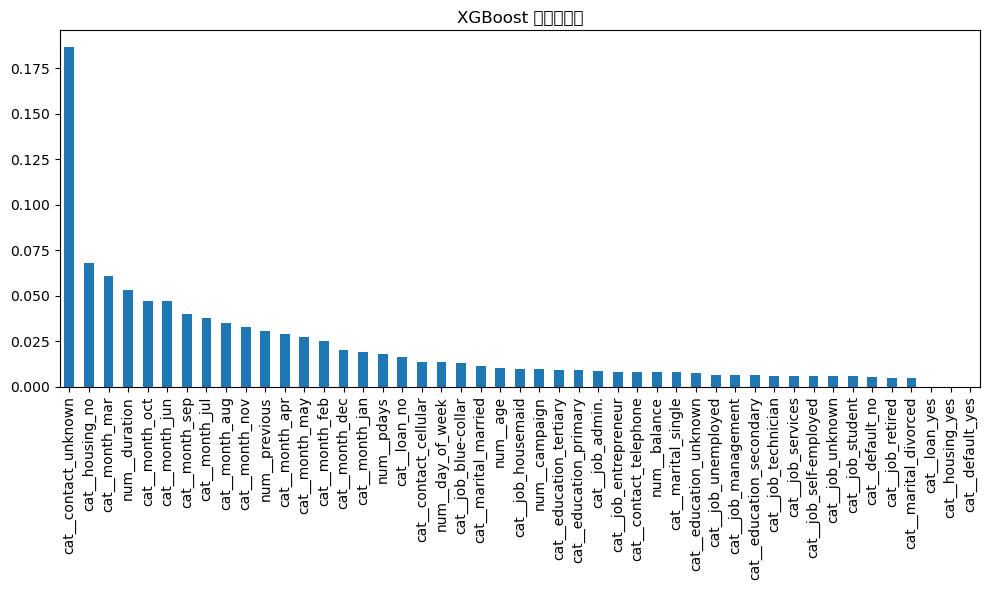

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from ucimlrepo import fetch_ucirepo

# 导入数据
bank_marketing = fetch_ucirepo(id=222)
X = bank_marketing.data.features
y = bank_marketing.data.targets['y']

# 预处理：处理缺失值
X['job'].fillna('unknown', inplace=True)
X['education'].fillna('unknown', inplace=True)
X['contact'].fillna('unknown', inplace=True)
X = X.drop(columns=['poutcome'])  # 删除缺失值过多的特征

# 检查连续性特征的分布并应用对数转换
continuous_cols = ['pdays', 'previous']
for col in continuous_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(X[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.savefig(f'{col}_distribution.png')
    plt.close()
    if (X[col] <= 0).any():
        print(f"{col} contains non-positive values, skipping log transformation.")
    else:
        X[col] = np.log(X[col] + 1)

# 识别数值和类别特征
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# 创建预处理管道
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# 应用预处理
X_processed = preprocessor.fit_transform(X)

# 编码目标变量
y = y.map({'yes': 1, 'no': 0})

# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

# 计算正负类权重
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

# 创建并训练 XGBoost 模型
xgb_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)

# 预测
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# 评估
print("XGBoost 分类报告：")
print(classification_report(y_test, y_pred_xgb))
print("XGBoost AUC-ROC 分数：", roc_auc_score(y_test, y_pred_proba_xgb))

# 特征重要性分析
feature_names = preprocessor.get_feature_names_out()
importances_xgb = xgb_model.feature_importances_
feature_importance_xgb = pd.Series(importances_xgb, index=feature_names).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
feature_importance_xgb.plot.bar()
plt.title('XGBoost 特征重要性')
plt.tight_layout()
plt.show()

In [3]:
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc

# 应用 SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 训练 XGBoost 模型
xgb_smote_model = XGBClassifier(
    scale_pos_weight=sum(y_train_resampled == 0) / sum(y_train_resampled == 1),
    random_state=42,
    eval_metric='logloss'
)
xgb_smote_model.fit(X_train_resampled, y_train_resampled)

# 预测
y_pred_smote = xgb_smote_model.predict(X_test)
y_pred_proba_smote = xgb_smote_model.predict_proba(X_test)[:, 1]

# 调整阈值以优化 F1 分数
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba_smote)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"最佳阈值（最大化 F1 分数）：{optimal_threshold:.3f}")

# 应用新阈值
y_pred_smote_adjusted = (y_pred_smote >= optimal_threshold).astype(int)

# 评估
print("SMOTE + 阈值调整 XGBoost 分类报告：")
print(classification_report(y_test, y_pred_smote_adjusted))
print("SMOTE + 阈值调整 AUC-ROC 分数：", roc_auc_score(y_test, y_pred_proba_smote))

# 计算 AUPRC
auprc = auc(recalls, precisions)
print("SMOTE + 阈值调整 AUPRC 分数：", auprc)

最佳阈值（最大化 F1 分数）：0.357
SMOTE + 阈值调整 XGBoost 分类报告：
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      7985
           1       0.60      0.55      0.58      1058

    accuracy                           0.90      9043
   macro avg       0.77      0.75      0.76      9043
weighted avg       0.90      0.90      0.90      9043

SMOTE + 阈值调整 AUC-ROC 分数： 0.9272701177657067
SMOTE + 阈值调整 AUPRC 分数： 0.587489421400775


In [4]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc

# 定义各个模型
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
xgb_model = XGBClassifier(scale_pos_weight=sum(y_train == 0) / sum(y_train == 1), random_state=42, eval_metric='logloss')
catboost_model = CatBoostClassifier(iterations=1000, auto_class_weights='Balanced', random_seed=42, verbose=0)

# 创建投票分类器
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('xgb', xgb_model),
        ('catboost', catboost_model)
    ],
    voting='soft'
)
voting_clf.fit(X_train, y_train)

# 预测
y_pred_voting = voting_clf.predict(X_test)
y_pred_proba_voting = voting_clf.predict_proba(X_test)[:, 1]

# 评估
print("投票分类器分类报告：")
print(classification_report(y_test, y_pred_voting))
print("投票分类器 AUC-ROC 分数：", roc_auc_score(y_test, y_pred_proba_voting))

# 计算 AUPRC
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_voting)
auprc = auc(recall, precision)
print("投票分类器 AUPRC 分数：", auprc)

投票分类器分类报告：
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      7985
           1       0.53      0.77      0.63      1058

    accuracy                           0.89      9043
   macro avg       0.75      0.84      0.78      9043
weighted avg       0.92      0.89      0.90      9043

投票分类器 AUC-ROC 分数： 0.9319127428200088
投票分类器 AUPRC 分数： 0.6051946400930515


In [5]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc

# 创建 CatBoost 模型
catboost_model = CatBoostClassifier(
    iterations=1000,
    auto_class_weights='Balanced',
    random_seed=42,
    verbose=100
)
catboost_model.fit(X_train, y_train)

# 预测
y_pred_catboost = catboost_model.predict(X_test)
y_pred_proba_catboost = catboost_model.predict_proba(X_test)[:, 1]

# 评估
print("CatBoost 分类报告：")
print(classification_report(y_test, y_pred_catboost))
print("CatBoost AUC-ROC 分数：", roc_auc_score(y_test, y_pred_proba_catboost))

# 计算 AUPRC
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_catboost)
auprc = auc(recall, precision)
print("CatBoost AUPRC 分数：", auprc)

Learning rate set to 0.04768
0:	learn: 0.6650498	total: 6.78ms	remaining: 6.77s
100:	learn: 0.3405479	total: 648ms	remaining: 5.76s
200:	learn: 0.3051470	total: 1.33s	remaining: 5.29s
300:	learn: 0.2826423	total: 1.96s	remaining: 4.55s
400:	learn: 0.2663593	total: 2.59s	remaining: 3.86s
500:	learn: 0.2537617	total: 3.21s	remaining: 3.19s
600:	learn: 0.2430445	total: 3.9s	remaining: 2.59s
700:	learn: 0.2336350	total: 4.51s	remaining: 1.92s
800:	learn: 0.2254350	total: 5.12s	remaining: 1.27s
900:	learn: 0.2179458	total: 5.77s	remaining: 634ms
999:	learn: 0.2110505	total: 6.39s	remaining: 0us
CatBoost 分类报告：
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      7985
           1       0.47      0.86      0.60      1058

    accuracy                           0.87      9043
   macro avg       0.72      0.86      0.76      9043
weighted avg       0.92      0.87      0.88      9043

CatBoost AUC-ROC 分数： 0.9322941289965944
CatBoost AUPRC 分数： 0.

In [6]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc

# 应用 SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 定义参数网格
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200]
}

# 创建网格搜索
grid_search = GridSearchCV(
    XGBClassifier(random_state=42, eval_metric='logloss'),
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)
grid_search.fit(X_train_resampled, y_train_resampled)

# 输出最佳参数
print("最佳参数：", grid_search.best_params_)

# 使用最佳模型预测
best_xgb_model = grid_search.best_estimator_
y_pred_grid = best_xgb_model.predict(X_test)
y_pred_proba_grid = best_xgb_model.predict_proba(X_test)[:, 1]

# 评估
print("SMOTE + 网格搜索 XGBoost 分类报告：")
print(classification_report(y_test, y_pred_grid))
print("SMOTE + 网格搜索 AUC-ROC 分数：", roc_auc_score(y_test, y_pred_proba_grid))

# 计算 AUPRC
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_grid)
auprc = auc(recall, precision)
print("SMOTE + 网格搜索 AUPRC 分数：", auprc)

最佳参数： {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100}
SMOTE + 网格搜索 XGBoost 分类报告：
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      7985
           1       0.58      0.63      0.60      1058

    accuracy                           0.90      9043
   macro avg       0.77      0.78      0.77      9043
weighted avg       0.91      0.90      0.91      9043

SMOTE + 网格搜索 AUC-ROC 分数： 0.9291176863992385
SMOTE + 网格搜索 AUPRC 分数： 0.5903767254003129
